In [163]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [118]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", '{:.2f}'.format)

##### Utils Functions

In [164]:
def convert_rooms_to_number(value):
    
    if 'B/R' in value:
        return int(re.findall('\d+', value)[0])  # Extract the number before "B/R"
    elif 'STUDIO' in value or 'UNKNOWN' in value:
        return 0  # Represent Studio as 0 bedrooms
    elif value in ['OFFICE', 'SHOP', 'PENTHOUSE', 'SINGLE ROOM', 'HOTEL']:
        return -1  # Assign -1 or another placeholder for non-bedroom categories
    elif 'SINGLE ROOM' in value:
        return 1
    else:
        return np.nan  # Handle unexpected values

In [184]:
# Remove outliers using IQR
def RemoveOutliers(data, cols):
    for col in cols:
        q1, q2, q3 = data.loc[:, col].quantile([0.25, 0.5, 0.75])
        iqr = q3 - q1
        lower_threshold = round(q1 - (1.5 * iqr), 2)
        upper_threshold = round(q3 + (1.5 * iqr), 2)
        median = data.loc[:, col].median()
        data.loc[ (data[col] < lower_threshold) | (data[col] > upper_threshold), col] = median

# Fill missing values with Unknown
def FillWithUnknown(data, cols):
    if isinstance(cols, list):
        for col in cols:
            data[col] = data[col].fillna("Unknown")
        
    elif isinstance(cols, str):
        data[cols] = data[cols].fillna("Unknown")

# Mapping rooms_en into numbers
def RoomsCleaner(df, col):
    FillWithUnknown(df, col)
    df[col] = df[col].str.upper()
    df[col] = df[col].apply(convert_rooms_to_number)
    

(rooms_en
 1 B/R          51856
 2 B/R          34823
 Studio         25262
 3 B/R          16513
 4 B/R           7209
 Office          2619
 5 B/R            662
 Shop             407
 PENTHOUSE         96
 6 B/R             85
 7 B/R              8
 Single Room        8
 Hotel              1
 Name: count, dtype: int64,
 np.int64(23257))

In [188]:
RoomsCleaner(transactions_df, "rooms_en")

rooms_en
 1    51856
 0    48519
 2    34823
 3    16513
 4     7209
-1     3131
 5      662
 6       85
 7        8
Name: count, dtype: int64 0


#### Exploratory Data Analysis

In [185]:
# Explore Datasets
rents_df = pd.read_csv("../data/snp_dld_2024_rents.csv", low_memory=False)
transactions_df = pd.read_csv("../data/snp_dld_2024_transactions.csv",)

##### EDA snp_dld_2024_transactions.csv

In [186]:
# transactions_df.info(show_counts=True)
# transactions_df.filter(regex="^(?!.*_ar$).*$").head(5)
transactions_df.head(5)

,transaction_number,transaction_datetime,transaction_type_en,transaction_type_id,transaction_subtype_en,transaction_subtype_id,registration_type_en,is_freehold_text,property_usage_en,property_usage_id,amount,total_buyer,total_seller,transaction_size_sqm,property_size_sqm,parcel_id,property_id,is_offplan,is_freehold,property_type_en,property_type_ar,property_type_id,property_subtype_en,property_subtype_ar,property_subtype_id,building_age,rooms_en,rooms_ar,parking,project_name_en,project_name_ar,area_en,area_ar,area_id,nearest_landmark_en,nearest_landmark_ar,nearest_metro_en,nearest_metro_ar,nearest_mall_en,nearest_mall_ar,master_project_en,master_project_ar,req_from,req_to,entry_id,meta_ts
0,102-10-2024,2024-01-11 11:05:38,Sales,1,Sell - Pre registration,0,Off-Plan,Free Hold,Residential,1,886320.00,2,1,66.47,66.47,6810655.00,0,t,t,Unit,وحدة,0,Flat,شقه سكنيه,0,0,1 B/R,غرفة,1,THE VYBE,ذا فايب,JUMEIRAH VILLAGE CIRCLE,جميرا فييلج سركل,0,Sports City Swimming Academy,أكاديمية المدينة الرياضية للسباحة,Dubai Internet City,مدينة دبي للإنترنت,Mall of the Emirates,مول الإمارات,NaN,NaN,2024-01-01,2024-01-31,94359,2024-09-26 09:45:23.369
1,102-1000-2024,2024-01-08 18:00:51,Sales,1,Sell - Pre registration,0,Off-Plan,Free Hold,Residential,1,1169025.00,1,1,70.76,70.76,6810196.00,0,t,t,Unit,وحدة,0,Flat,شقه سكنيه,0,0,1 B/R,غرفة,1,Elitz 3 By Danube,إليتز3 من دانوب,JUMEIRAH VILLAGE CIRCLE,جميرا فييلج سركل,0,Sports City Swimming Academy,أكاديمية المدينة الرياضية للسباحة,Nakheel Metro Station,محطة مترو النخيل,Marina Mall,مارينا مول,NaN,NaN,2024-01-01,2024-01-31,94359,2024-09-26 09:45:23.369
2,102-1001-2024,2024-01-08 18:00:57,Sales,1,Sell - Pre registration,0,Off-Plan,Non Free Hold,Residential,1,1285588.11,2,1,115.33,115.33,6000116.00,0,t,f,Unit,وحدة,0,Flat,شقه سكنيه,0,0,2 B/R,غرفتان,1,TRIA BY DEYAAR,تريا من ديار,SILICON OASIS,واحة سيليكون,0,IMG World Adventures,آي إم جي وورلد أدفينتشرز,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,2024-01-31,94359,2024-09-26 09:45:23.369
3,102-1002-2024,2024-01-08 18:01:03,Sales,1,Sell - Pre registration,0,Off-Plan,Free Hold,Residential,1,2636200.00,1,1,110.02,110.02,NaN,0,t,t,Unit,وحدة,0,Flat,شقه سكنيه,0,0,2 B/R,غرفتان,1,Oceanz 1 By Danube,أوشنز 1 من دانوب,DUBAI MARITIME CITY,مدينة دبي الملاحية,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,2024-01-31,94359,2024-09-26 09:45:23.369
4,102-1003-2024,2024-01-08 18:01:07,Sales,1,Sell - Pre registration,0,Off-Plan,Free Hold,Residential,1,1681899.00,1,1,73.32,73.32,NaN,0,t,t,Unit,وحدة,0,Flat,شقه سكنيه,0,0,1 B/R,غرفة,1,Club Drive,كلوب درايف,Hadaeq Sheikh Mohammed Bin Rashid,حدائق الشيخ محمد بن راشد,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,2024-01-31,94359,2024-09-26 09:45:23.369


In [175]:
transactions_df.loc[:, OHE_cols + LE_cols + target_col].isna().sum()

# ["is_freehold", "nearest_landmark_en"] ffill()

transaction_type_en           0
registration_type_en          0
is_freehold_text              0
property_usage_en             0
is_offplan                    0
is_freehold                 684
nearest_landmark_en       47412
property_type_en              0
rooms_en                  23257
nearest_mall_en           66842
transaction_subtype_en        0
property_subtype_en        1392
area_en                       0
project_name_en           24760
nearest_metro_en          65982
amount                        0
dtype: int64

In [152]:
transactions_df.groupby(['property_subtype_en', "rooms_en"]).agg({'amount': 'count'}).reset_index()

,property_subtype_en,rooms_en,amount
0,Agricultural,Unknown,31
1,Airport,Unknown,433
2,Building,Unknown,9
3,Clinic,Unknown,2
4,Commercial,Unknown,4493
5,Commercial / Offices / Residential,Unknown,6
6,Consulate,Unknown,7
7,Electricity Station,Unknown,2
8,Exhbition Center,Unknown,1
9,Flat,1 B/R,50530


In [126]:
transactions_df.loc[:, OHE_cols + LE_cols + target_col].head(10)

,transaction_type_en,registration_type_en,is_freehold_text,property_usage_en,is_offplan,is_freehold,nearest_landmark_en,property_type_en,rooms_en,nearest_mall_en,transaction_subtype_en,property_subtype_en,area_en,project_name_en,nearest_metro_en,amount
0,Sales,Off-Plan,Free Hold,Residential,t,t,Sports City Swimming Academy,Unit,1 B/R,Mall of the Emirates,Sell - Pre registration,Flat,JUMEIRAH VILLAGE CIRCLE,THE VYBE,Dubai Internet City,886320.00
1,Sales,Off-Plan,Free Hold,Residential,t,t,Sports City Swimming Academy,Unit,1 B/R,Marina Mall,Sell - Pre registration,Flat,JUMEIRAH VILLAGE CIRCLE,Elitz 3 By Danube,Nakheel Metro Station,1169025.00
2,Sales,Off-Plan,Non Free Hold,Residential,t,f,IMG World Adventures,Unit,2 B/R,NaN,Sell - Pre registration,Flat,SILICON OASIS,TRIA BY DEYAAR,NaN,1285588.11
3,Sales,Off-Plan,Free Hold,Residential,t,t,NaN,Unit,2 B/R,NaN,Sell - Pre registration,Flat,DUBAI MARITIME CITY,Oceanz 1 By Danube,NaN,2636200.00
4,Sales,Off-Plan,Free Hold,Residential,t,t,NaN,Unit,1 B/R,NaN,Sell - Pre registration,Flat,Hadaeq Sheikh Mohammed Bin Rashid,Club Drive,NaN,1681899.00
5,Sales,Off-Plan,Free Hold,Residential,t,t,Sports City Swimming Academy,Unit,1 B/R,Ibn-e-Battuta Mall,Sell - Pre registration,Flat,JUMEIRAH VILLAGE TRIANGLE,555 PARK VIEWS,Harbour Tower,1042720.00
6,Sales,Off-Plan,Free Hold,Residential,t,t,Dubai International Airport,Unit,3 B/R,City Centre Mirdif,Sell - Pre registration,Flat,DUBAI CREEK HARBOUR,Creek Beach - Savanna-Cedar-Mangrove,Creek Metro Station,3726888.00
7,Sales,Off-Plan,Non Free Hold,Residential,t,f,IMG World Adventures,Unit,Studio,NaN,Sell - Pre registration,Flat,SILICON OASIS,TRIA BY DEYAAR,NaN,552357.00
8,Sales,Off-Plan,Free Hold,Residential,t,t,Downtown Dubai,Unit,Studio,Dubai Mall,Sell - Pre registration,Flat,DUBAI HEALTHCARE CITY - PHASE 2,AL WALEED GARDEN 2,Al Jadaf Metro Station,533400.00
9,Sales,Off-Plan,Non Free Hold,Residential,t,f,IMG World Adventures,Unit,2 B/R,NaN,Sell - Pre registration,Flat,SILICON OASIS,TRIA BY DEYAAR,NaN,1208023.00


In [100]:
OHE_cols = ["transaction_type_en", "registration_type_en", "is_freehold_text", "property_usage_en", "is_offplan",
             "is_freehold", "nearest_landmark_en", "property_type_en", "rooms_en", "nearest_mall_en"]

LE_cols =   ["transaction_subtype_en", "property_subtype_en", "area_en", "project_name_en", "nearest_metro_en"]

target_col = ['amount']

<Axes: title={'center': 'Property Size SQM'}>

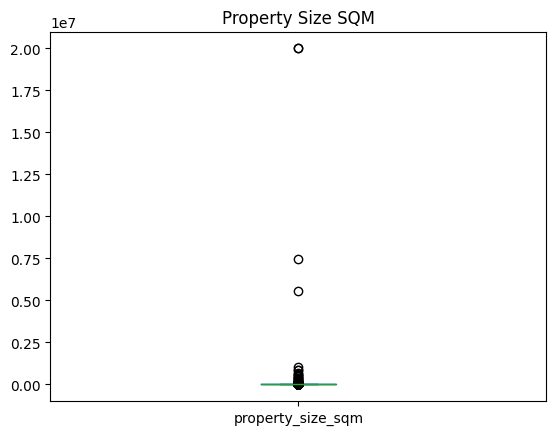

In [30]:
transactions_df['property_size_sqm'].plot(kind='box', title='Property Size SQM')

In [27]:
### Drop
    # [transaction_number, transaction_datetime, transaction_type_id, transaction_size_sqm, transaction_subtype_id, property_usage_id,
    #  property_id, property_type_ar, property_type_id, building_age, rooms_ar, project_name_en, property_subtype_ar,
    #  property_subtype_id, area_ar, area_id, nearest_landmark_ar, nearest_metro_ar, nearest_mall_ar, master_project_ar, req_from,
    #  req_to, entry_id, meta_ts, master_project_en]

### Encoding
    ## Label Encoding
    # ["transaction_subtype_en", "property_subtype_en", "area_en", "project_name_en", "nearest_metro_en"]

    ## One Hot Encoding
    ## ["transaction_type_en", "registration_type_en", "is_freehold_text", "property_usage_en", "is_offplan", "is_freehold",
    #  "nearest_landmark_en", "property_type_en", "rooms_en", "nearest_mall_en"]

### Engineered Features
    # [transaction_age_in_days] -> transactions_df.loc[:, 'transaction_age_in_days'] = round((pd.Timestamp.now() - pd.to_datetime(transactions_df['transaction_datetime'])).dt.total_seconds() / (60 * 60 * 24))



157600

##### EDA snp_dld_2024_rents.csv

In [23]:
rents_df.head(10)

,ejari_contract_number,registration_date,contract_start_date,contract_end_date,version_number,version_text,contract_amount,annual_amount,is_freehold,is_freehold_text,property_size_sqm,parcel_id,property_id,land_property_id,property_type_en,property_type_ar,property_subtype_en,property_subtype_ar,property_usage_en,property_usage_ar,property_usage_id,total_properties,rooms,parking,project_name_en,project_name_ar,area_en,area_ar,area_id,nearest_landmark_en,nearest_landmark_ar,nearest_metro_en,nearest_metro_ar,nearest_mall_en,nearest_mall_ar,master_project_en,master_project_ar,ejari_property_type_id,ejari_property_sub_type_id,req_from,req_to,entry_id,meta_ts
0,120130625001365,2024-01-24 11:14:33,2024-01-01,2024-12-31,12,Renewed,58000.00,58000.0,f,Non Free Hold,120.76,2410596.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Al Nahda Second,النهده الثانيه,0,Dubai International Airport,مطار دبي الدولي,Al Nahda Metro Station,محطة مترو النهضة,City Centre Mirdif,سيتي سنتر مردف,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
1,120130626005726,2024-01-09 16:48:47,2024-03-18,2025-03-17,12,Renewed,88000.00,88000.0,t,Free Hold,159.03,2514114.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Mirdif,مردف,0,Dubai International Airport,مطار دبي الدولي,Rashidiya Metro Station,محطة مترو الراشدية,City Centre Mirdif,سيتي سنتر مردف,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
2,120130626007829,2024-01-16 11:39:26,2024-01-01,2024-12-31,12,Renewed,94000.00,94000.0,f,Non Free Hold,60.94,1230681.0,0,0,Unit,وحدة,Shop,محل,Commercial,تجاري,0,1,NaN,NaN,NaN,NaN,Al Muteena,المطينه,0,Dubai International Airport,مطار دبي الدولي,Salah Al Din Metro Station,محطة مترو صلاح الدين,Dubai Mall,مول دبي,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
3,120130627008661,2024-01-15 18:28:05,2024-01-01,2024-12-31,12,Renewed,66000.00,66000.0,f,Non Free Hold,108.88,3730405.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Al Barsha First,البرشاء الاولى,0,Burj Al Arab,برج العرب,Sharaf Dg Metro Station,محطة مترو شرف دي جي,Mall of the Emirates,مول الإمارات,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
4,120130627009439,2024-01-22 13:34:29,2024-01-01,2024-12-31,12,Renewed,31200.00,31200.0,f,Non Free Hold,57.60,2320537.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Al Qusais First,القصيص الاولى,0,Dubai International Airport,مطار دبي الدولي,Airport Free Zone,المنطقة الحرة بالمطار,City Centre Mirdif,سيتي سنتر مردف,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
5,120130630014940,2024-01-05 15:45:05,2024-01-08,2024-04-07,12,Renewed,10106.25,40425.0,f,Non Free Hold,106.74,2450405.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Muhaisanah Fourth,محيصنه الرابعه,0,Dubai International Airport,مطار دبي الدولي,Etisalat Metro Station,محطة مترو اتصالات,City Centre Mirdif,سيتي سنتر مردف,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
6,120130701019951,2024-01-09 16:49:15,2023-11-08,2024-02-07,14,Renewed,12750.00,51000.0,t,Free Hold,103.05,2514313.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Mirdif,مردف,0,Dubai International Airport,مطار دبي الدولي,Rashidiya Metro Station,محطة مترو الراشدية,City Centre Mirdif,سيتي سنتر مردف,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
7,120130701021228,2024-01-24 12:37:03,2023-12-21,2024-12-20,13,Renewed,96000.00,96000.0,f,Non Free Hold,148.00,3140136.0,0,0,Unit,وحدة,Flat,شقه,Residential,سكني,0,1,NaN,NaN,NaN,NaN,Um Hurair First,ام هرير الاولى,0,Dubai International Airport,مطار دبي الدولي,Burjuman Metro Station,محطة مترو برجمان,Dubai Mall,مول دبي,NaN,NaN,0,0,2024-01-01,2024-01-31,94368,2024-09-26 11:18:46.859
8,120130701021441,2024-01-04 12:27:24,2024-01-01,2024-12-31,12,Renewed,162350.00,162350.0,f,Non Free Hold,302.00,3640312.0,0,0,Unit,وحدة,Warehouse complex,مجمع مخازن,Industrial,صناعي,0,1,NaN,NaN,NaN,NaN,Al Goze Industrial First,القوز الصناعيه الاولى,0,Burj Al 

(747408, 43) (162806, 46)
